## San Francisco Restaurant Health Scores and Violations

This dataset was pulled from Kaggle. The link to can be found [here](https://www.kaggle.com/san-francisco/sf-restaurant-scores-lives-standard).

We will try to see if pulling in Yelp information can help predict a restaurant's health scores.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stats
import seaborn as sns

In [4]:
#this has duplicate entries (we'll create our df of non-dups later)
temp_df = pd.read_csv('restaurant-scores-lives-standard.csv')

In [5]:
temp_df = temp_df.drop(columns=['business_id', 'business_phone_number', 'business_city', 'business_state', 'business_location', 'business_address', 'Zip Codes'])
#let's drop any records with null target values
temp_df = temp_df.dropna(subset=['inspection_score']).reset_index()

In [6]:
temp_df.shape

(39514, 17)

In [7]:
temp_df.loc[temp_df['business_name'] == 'Parada 22']

,index,business_name,business_postal_code,business_latitude,business_longitude,inspection_id,inspection_date,inspection_score,inspection_type,violation_id,violation_description,risk_category,Neighborhoods,Police Districts,Supervisor Districts,Fire Prevention Districts,Analysis Neighborhoods
17,40,Parada 22,94117,37.769303,-122.451961,62051_20180514,2018-05-14T00:00:00.000,86.0,Routine - Unscheduled,62051_20180514_103154,Unclean or degraded floors walls or ceilings,Low Risk,9.0,5.0,11.0,15.0,3.0
664,1140,Parada 22,94117,37.769303,-122.451961,62051_20180514,2018-05-14T00:00:00.000,86.0,Routine - Unscheduled,62051_20180514_103133,Foods not protected from contamination,Moderate Risk,9.0,5.0,11.0,15.0,3.0
713,1224,Parada 22,94117,37.769303,-122.451961,62051_20180514,2018-05-14T00:00:00.000,86.0,Routine - Unscheduled,62051_20180514_103132,Improper thawing methods,Moderate Risk,9.0,5.0,11.0,15.0,3.0
1866,3010,Parada 22,94117,37.769303,-122.451961,62051_20180514,2018-05-14T00:00:00.000,86.0,Routine - Unscheduled,62051_20180514_103116,Inadequate food safety knowledge or lack of ce...,Moderate Risk,9.0,5.0,11.0,15.0,3.0
29390,40887,Parada 22,94117,37.769303,-122.451961,62051_20190509,2019-05-09T00:00:00.000,88.0,Routine - Unscheduled,62051_20190509_103154,Unclean or degraded floors walls or ceilings,Low Risk,9.0,5.0,11.0,15.0,3.0
30965,42869,Parada 22,94117,37.769303,-122.451961,62051_20190509,2019-05-09T00:00:00.000,88.0,Routine - Unscheduled,62051_20190509_103124,Inadequately cleaned or sanitized food contact...,Moderate Risk,9.0,5.0,11.0,15.0,3.0
32390,44707,Parada 22,94117,37.769303,-122.451961,62051_20190509,2019-05-09T00:00:00.000,88.0,Routine - Unscheduled,62051_20190509_103144,Unapproved or unmaintained equipment or utensils,Low Risk,9.0,5.0,11.0,15.0,3.0


Well, there are multiple entries for the same inspection. We really only want one, so let's make that happen.

But first, let's remove some records that don't make sense.

In [8]:
#drop rows where there is no violation description, but they still had points subtracted
drop_index = temp_df.loc[(temp_df.violation_description.isnull()) & (temp_df.inspection_score < 100)].index
temp_df.drop(drop_index, inplace=True)

In [9]:
temp_df.loc[temp_df.violation_description.isnull(), 'inspection_score'].mean()

100.0

In [10]:
#no violation description means there was no violation - that's why they got a 100!
temp_df['violation_description'].fillna('No violation', inplace=True)
#null risk category means there was no violation and no risk
temp_df.risk_category.fillna('No Violation', inplace=True)

Ok, time to create a new df without any duplicate entries.

In [11]:
#loop through all the inspection id's and create a df of only one instance
ins_ids = temp_df['inspection_id'].unique()

names = []
zip_codes = []
lat = []
long = []
ids = []
date = []
score = []
ins_type = []
viol_id = []
neighborhoods = []
pol_dist = []
sup_dist = []
fire_dist = []
analy_nei = []
num_violations = []

for id in ins_ids:
    #new df for our one restaurant
    restaurant = temp_df.loc[temp_df.inspection_id == id]
    #sometimes there are no data for the inspection id?
    if (len(restaurant) > 0):
        #grab the index of the first one
        index = restaurant.index[0]
        #start appending some values
        names.append(restaurant['business_name'][index])
        zip_codes.append(restaurant['business_postal_code'][index])
        lat.append(restaurant['business_latitude'][index])
        long.append(restaurant['business_longitude'][index])
        ids.append(restaurant['inspection_id'][index])
        date.append(restaurant['inspection_date'][index])
        score.append(restaurant['inspection_score'][index])
        ins_type.append(restaurant['inspection_type'][index])
        viol_id.append(restaurant['violation_id'][index])
        neighborhoods.append(restaurant['Neighborhoods'][index])
        pol_dist.append(restaurant['Police Districts'][index])
        sup_dist.append(restaurant['Supervisor Districts'][index])
        fire_dist.append(restaurant['Fire Prevention Districts'][index])
        analy_nei.append(restaurant['Analysis Neighborhoods'][index])
        #if the score is 100, then there were no violations. All the others are counted and appended
        if (restaurant['inspection_score'][index] == 100):
            num_violations.append(0)
        else:
            num_violations.append(len(restaurant))

In [12]:
#we have the unique entires in lists. now let's add them to our df
df = pd.DataFrame()

df['business_name'] = names
df['business_postal_code'] =  zip_codes
df['business_latitude'] =  lat
df['business_longitude'] = long
df['inspection_id'] = ids
df['inspection_date'] = date
df['inspection_score'] =  score
df['inspection_type'] =  ins_type
df['violation_id'] =  viol_id
df['Neighborhoods'] =  neighborhoods
df['Police Districts'] =  pol_dist
df['Supervisor Districts'] =  sup_dist
df['Fire Prevention Districts'] =  fire_dist
df['Analysis Neighborhoods'] =  analy_nei
df['num_violations'] =  num_violations

In [13]:
print(df.inspection_id.nunique())
print(len(df))

12020
12020


Let's create counts of our different risk categories. A new feature!

In [14]:
low_risk = []
medium_risk = []
high_risk = []
no_risk_violation = []

ins_ids = temp_df['inspection_id'].unique()

for id in ins_ids:
    #each restaurant and the unique category counts
    restaurant = temp_df.loc[temp_df.inspection_id == id]
    counts = restaurant['risk_category'].value_counts()
    
    try:
        low_risk.append(counts['Low Risk'])
    except:
        low_risk.append(0)
        
    try:
        medium_risk.append(counts['Moderate Risk'])
    except:
        medium_risk.append(0)
        
    try:
        high_risk.append(counts['High Risk'])
    except:
        high_risk.append(0)
        
    try:
        no_risk_violation.append(counts['No Violation'])
    except:
        no_risk_violation.append(0)

In [15]:
#add our counts lists into our new df
df['low_risk_count'] = low_risk
df['medium_risk_count'] = medium_risk
df['high_risk_count'] = high_risk
df['no_risk_count'] = no_risk_violation

We can also create some calendar entry information!

In [16]:
import calendar
df['inspection_date'] = pd.to_datetime(df['inspection_date'])


df['Year'] = df['inspection_date'].dt.year
df['Month'] = df['inspection_date'].dt.month
df['Date'] = df['inspection_date'].dt.day
df['Day'] = df['inspection_date'].apply(lambda x: calendar.day_name[x.weekday()])

### Pull in our yelp data and merge into our new dataframe

In [17]:
#load our yelp reviews dataset
yelp_df = pd.read_csv('yelp_business.csv')

In [18]:
yelp_df.rename(columns={'id' : 'yelp_id', 'rating' : 'yelp_rating'}, inplace=True)

In [19]:
yelp_df.dropna(how='all', inplace=True)

In [20]:
#make everything lower so the merge goes better
df.business_name = df.business_name.apply(lambda x: x.lower())

yelp_df.name = yelp_df.name.apply(lambda x: x.lower())

In [21]:
#convert our '$' values into a numeric measure
yelp_df.price = yelp_df.price.apply(lambda x: len(x) if type(x) != float else np.nan)
yelp_df.price.fillna(yelp_df.price.median(), inplace=True)

In [22]:
df = df.merge(yelp_df, how='left', left_on='business_name', right_on='name')

In [23]:
df.shape

(12767, 29)

Let's do some data cleaning and filling null values.

In [24]:
filling_nans = ['Neighborhoods', 'Police Districts', 'Supervisor Districts', 'Fire Prevention Districts', 'Analysis Neighborhoods']

for column in filling_nans:
    df[column].fillna(df[column].median(), inplace=True)

Let's see if we can find any missing values that have yelp information AND only have a few missing values.

In [25]:
df = df.drop(columns=['violation_id', 'business_latitude', 'business_longitude'])

Found a few that we can fill in.

In [26]:
for i in range(len(df.business_name)):
    if (df['business_name'][i] == 'ghirardelli chocolate'):
        df['business_postal_code'][i] = 94103

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [27]:
for i in range(len(df.business_name)):
    if (df['business_name'][i] == 'sunrise deli'):
        df['business_postal_code'][i] = 94122

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [28]:
null = df.isnull().sum() / len(df) * 100
null[null > 0]

business_postal_code     2.357641
name                    69.530822
yelp_id                 69.530822
yelp_rating             69.530822
price                   69.530822
review_rating           69.530822
review_sentiment        69.530822
dtype: float64

So, which ones are missing?

In [29]:
df.dropna(inplace=True)

In [30]:
df.shape

(3876, 26)

In [31]:
print('The earliest date was {}'.format(min(df['inspection_date'])))
print('The latest date was {}'.format(max(df['inspection_date'])))

The earliest date was 2016-08-02 00:00:00
The latest date was 2019-08-01 00:00:00


In [32]:
numeric_columns = df.select_dtypes(include=['float64'])
cat_cols = df.loc[:, ~df.columns.isin(numeric_columns)]
cat_cols = cat_cols.drop(columns=['inspection_date', 'business_name', 'name', 'yelp_id', 'inspection_id'])

What does the inspection score (our target) variable look like?

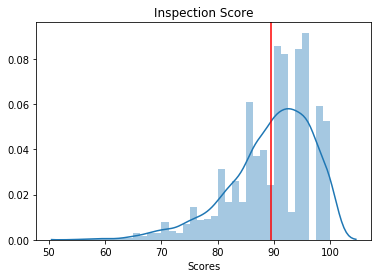

In [33]:
sns.distplot(df['inspection_score'])
plt.title('Inspection Score')
plt.xlabel('Scores')
plt.axvline(df['inspection_score'].mean(), color='red')
plt.show()

In [34]:
df['inspection_score'].describe()

count    3876.000000
mean       89.528122
std         7.427168
min        55.000000
25%        86.000000
50%        90.000000
75%        96.000000
max       100.000000
Name: inspection_score, dtype: float64

inspection_score
Correlation: 1.0 -- p_value: 0.0


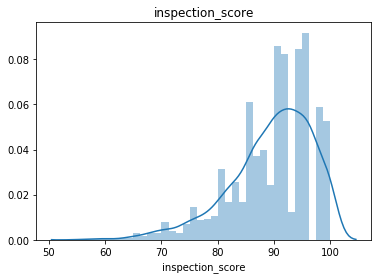

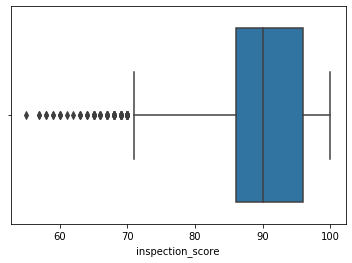

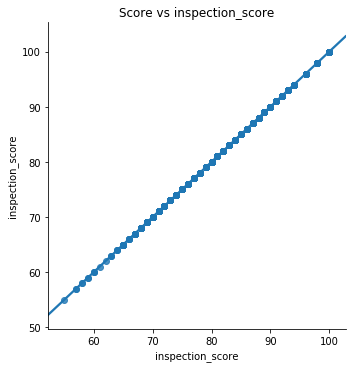


Neighborhoods
Correlation: 0.043661640225113194 -- p_value: 0.006554188727838461


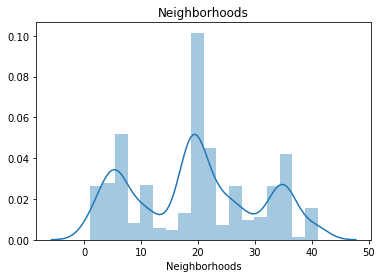

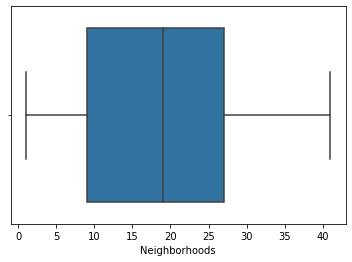

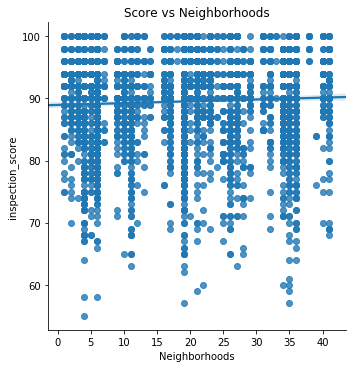


Police Districts
Correlation: -0.014810880893194628 -- p_value: 0.3566109962887313


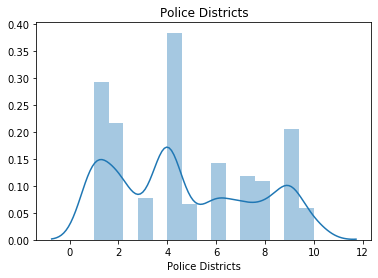

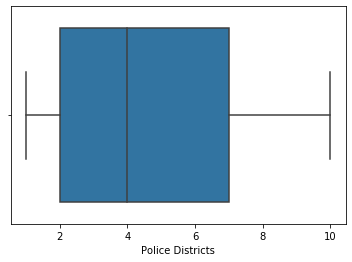

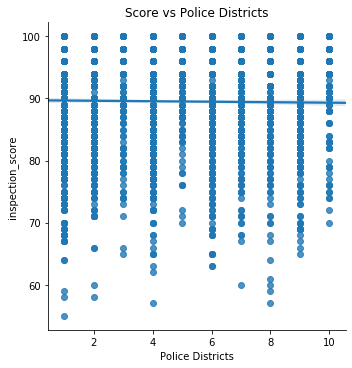


Supervisor Districts
Correlation: 0.04605084345441011 -- p_value: 0.004135872190958971


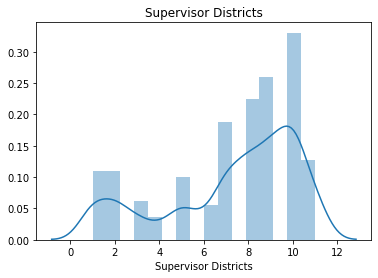

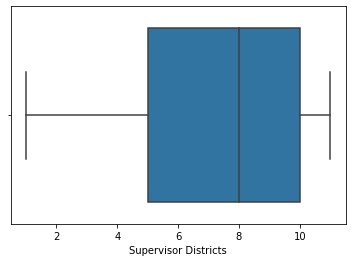

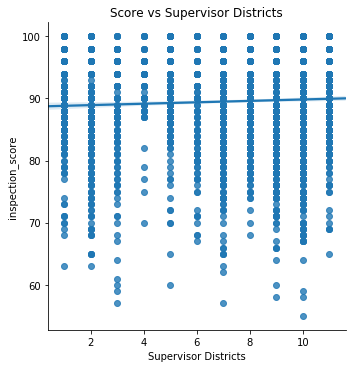


Fire Prevention Districts
Correlation: 0.026655976064865437 -- p_value: 0.09705641024270492


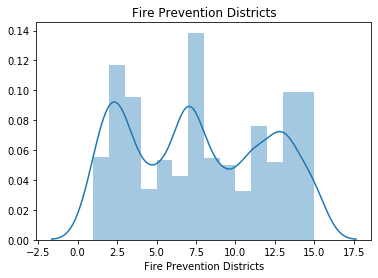

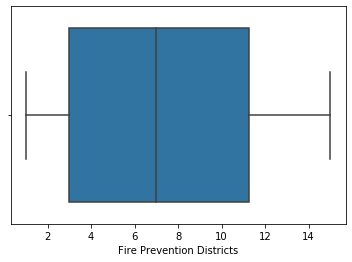

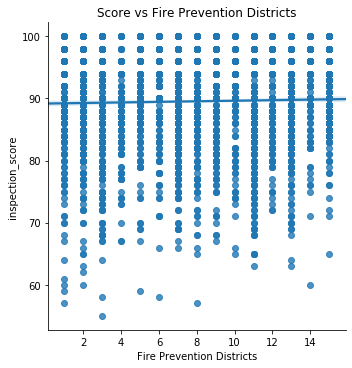


Analysis Neighborhoods
Correlation: 0.020241554966851205 -- p_value: 0.2077011771971872


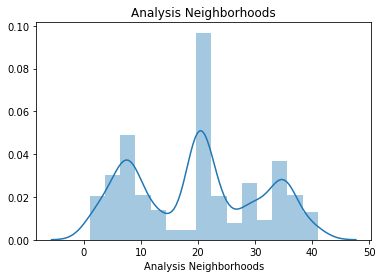

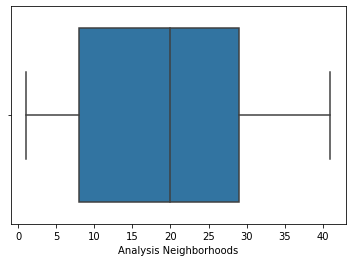

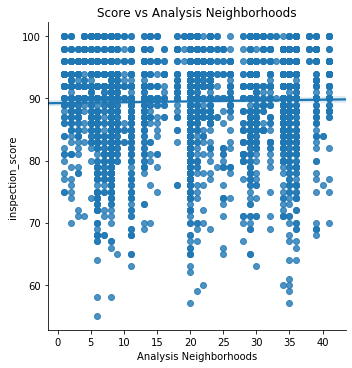


yelp_rating
Correlation: 0.10101164507753321 -- p_value: 2.9225364320570086e-10


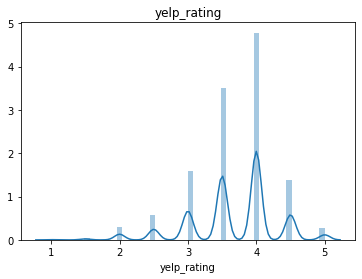

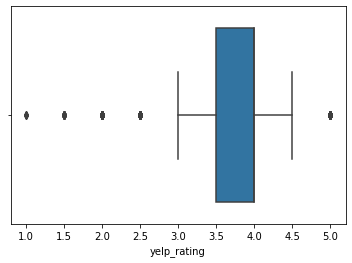

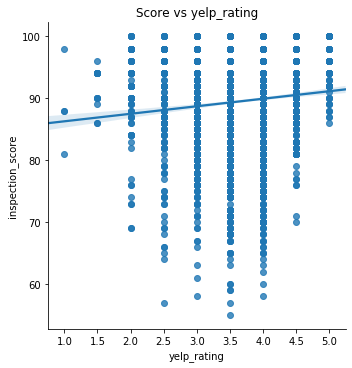


price
Correlation: 0.04618688697368842 -- p_value: 0.004026363708416817


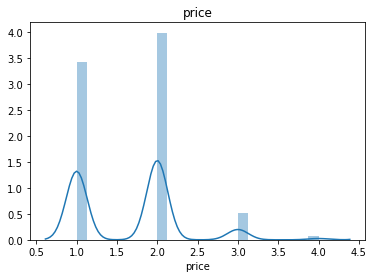

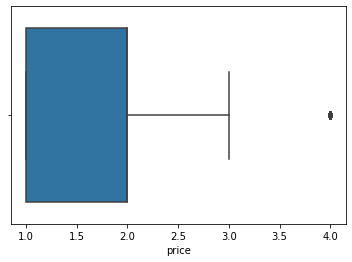

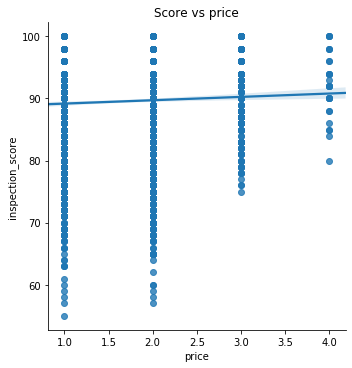


review_rating
Correlation: 0.07049774690388072 -- p_value: 1.1176303805349185e-05


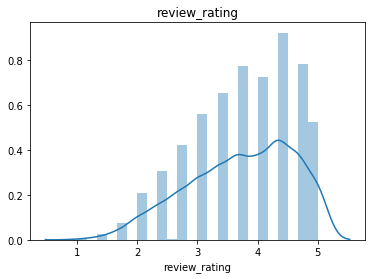

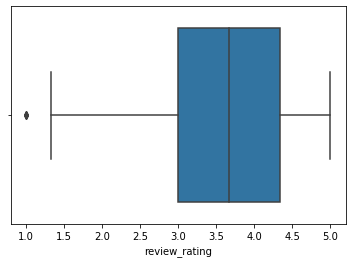

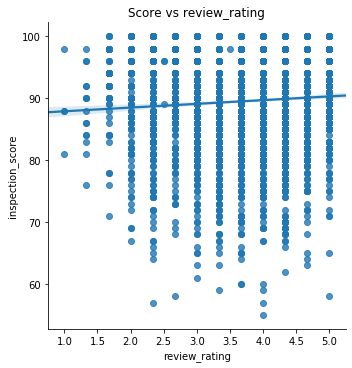


review_sentiment
Correlation: 0.08430155139460577 -- p_value: 1.4716507977900908e-07


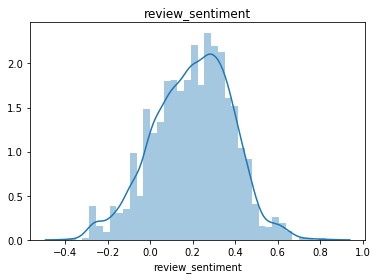

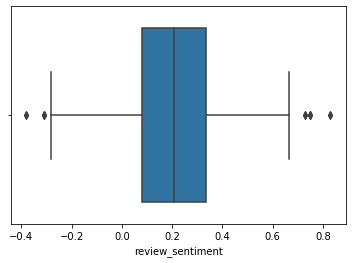

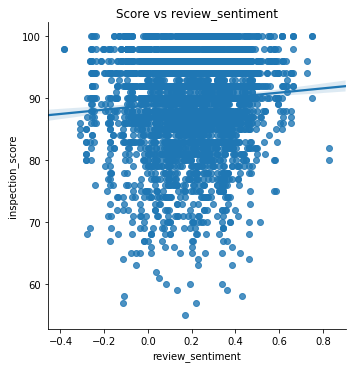

In [35]:
for column in numeric_columns:
    corr, p_value = stats.pearsonr(df[column], df.inspection_score)
    print('{}'.format(column))
    print('Correlation: {} -- p_value: {}'.format(corr, p_value))
    sns.distplot(df[column])
    plt.title('{}'.format(column))
    plt.show()
    
    sns.boxplot(df[column])
    plt.show()
    
    sns.lmplot(x=column, y='inspection_score', data=df)
    plt.title('Score vs {}'.format(column))
    plt.show()
    print('')

In [36]:
columns = numeric_columns.columns
r_squared = []
p_value = []
for column in numeric_columns:
    corr, p = stats.pearsonr(df[column], df.inspection_score)
    r_squared.append(abs(corr))
    p_value.append(p)
    
r_values = pd.DataFrame()
r_values['feature'] = columns
r_values['r_squared'] = r_squared
r_values['p_value'] = p_value

r_values = r_values.sort_values(by='r_squared', ascending=False).reset_index()
r_values[1:]

,index,feature,r_squared,p_value
1,6,yelp_rating,0.101012,2.922536e-10
2,9,review_sentiment,0.084302,1.471651e-07
3,8,review_rating,0.070498,1.117630e-05
4,7,price,0.046187,4.026364e-03
5,3,Supervisor Districts,0.046051,4.135872e-03
6,1,Neighborhoods,0.043662,6.554189e-03
7,4,Fire Prevention Districts,0.026656,9.705641e-02
8,5,Analysis Neighborhoods,0.020242,2.077012e-01
9,2,Police Districts,0.014811,3.566110e-01


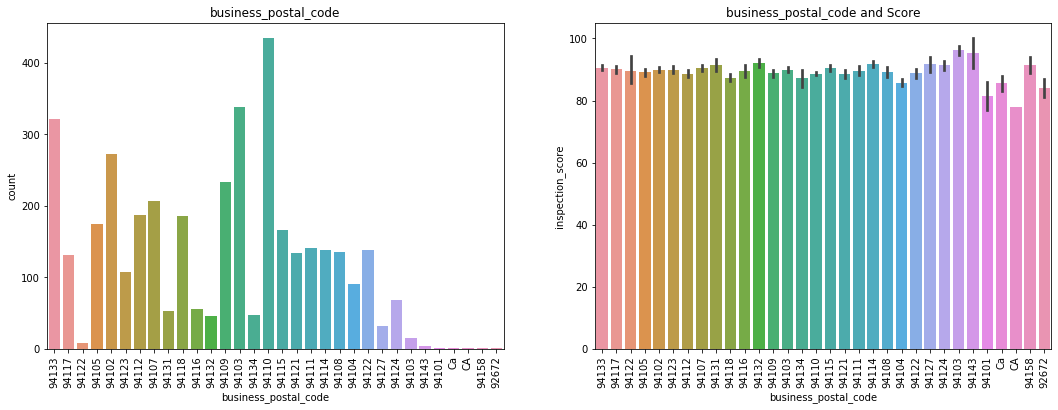

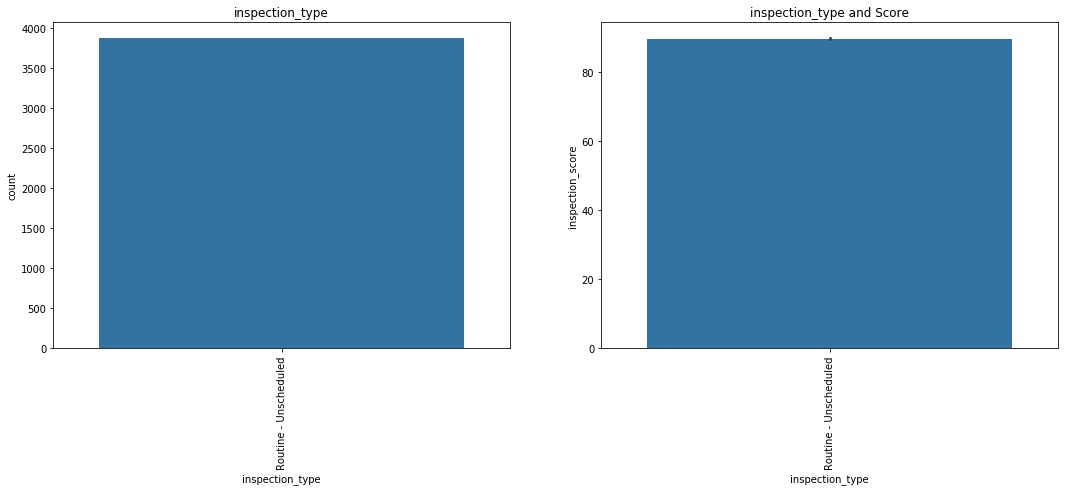

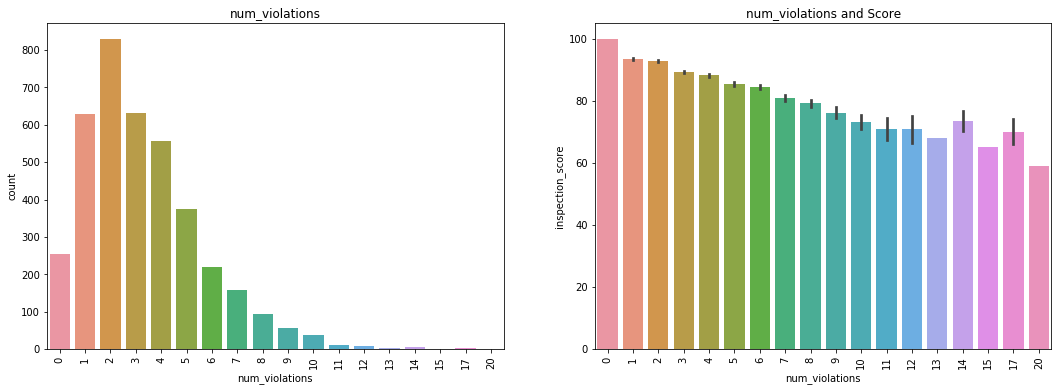

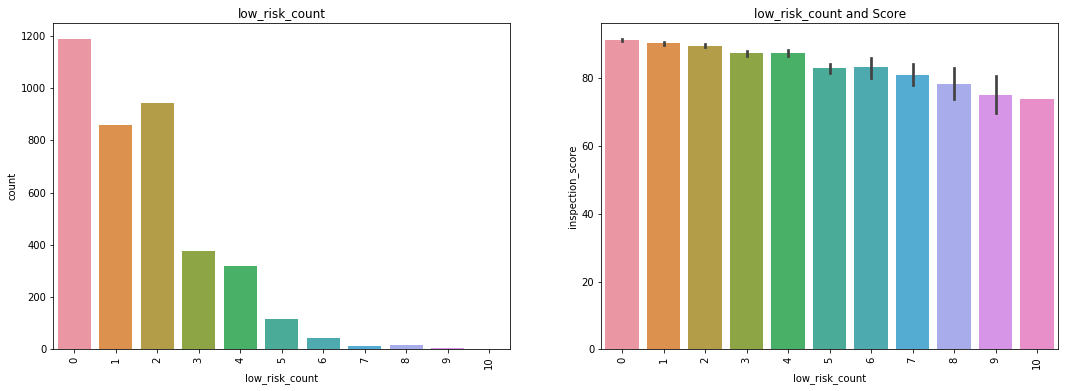

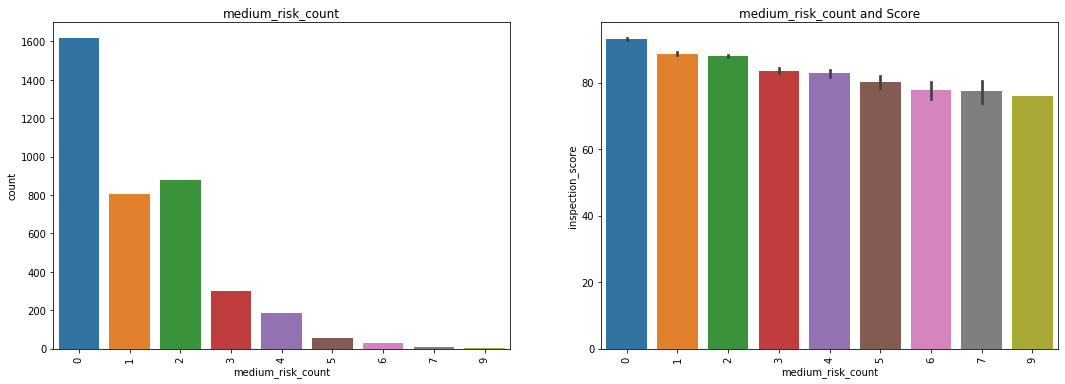

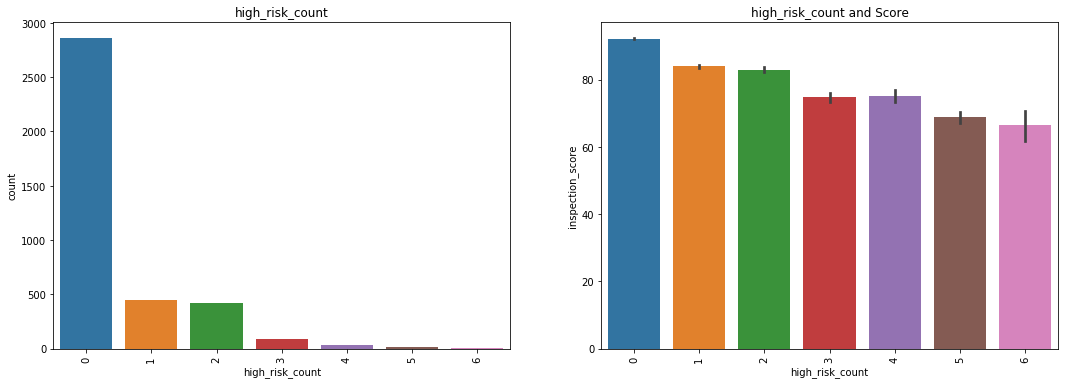

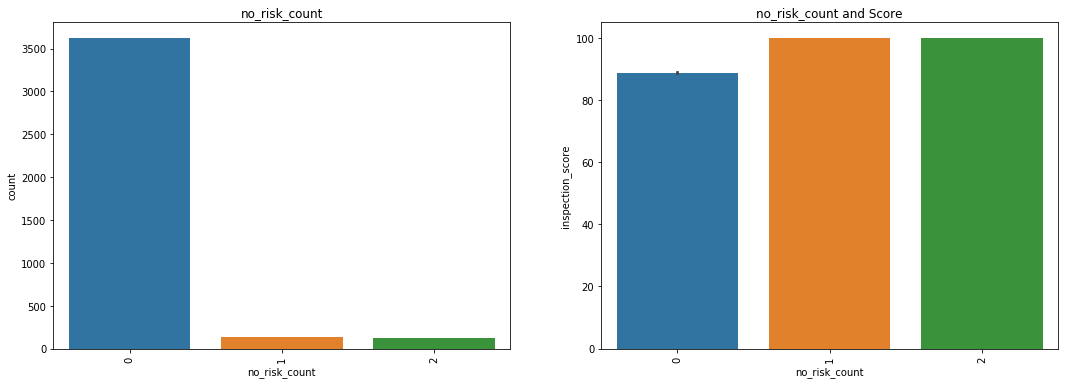

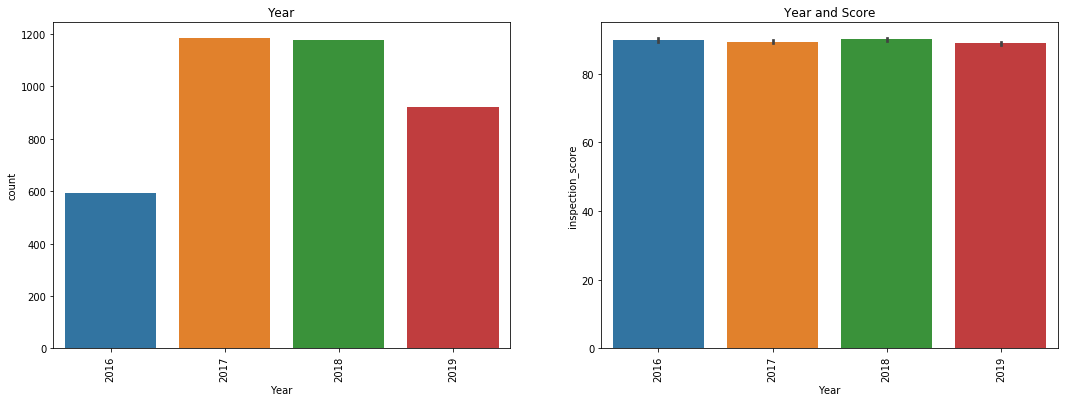

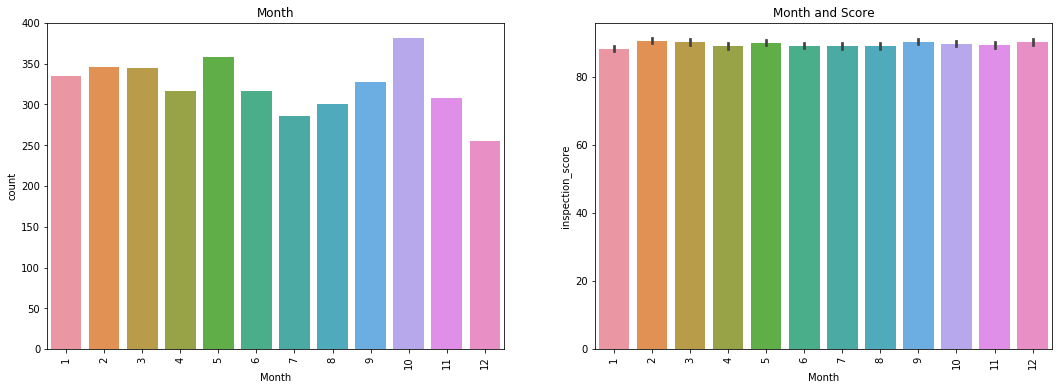

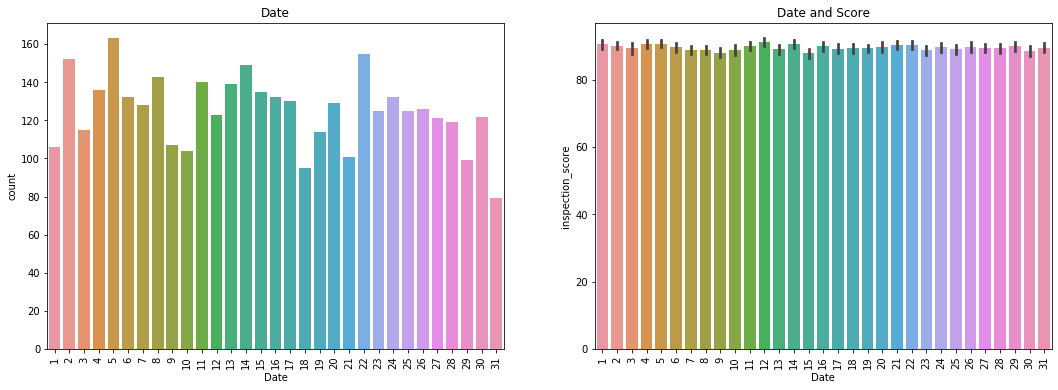

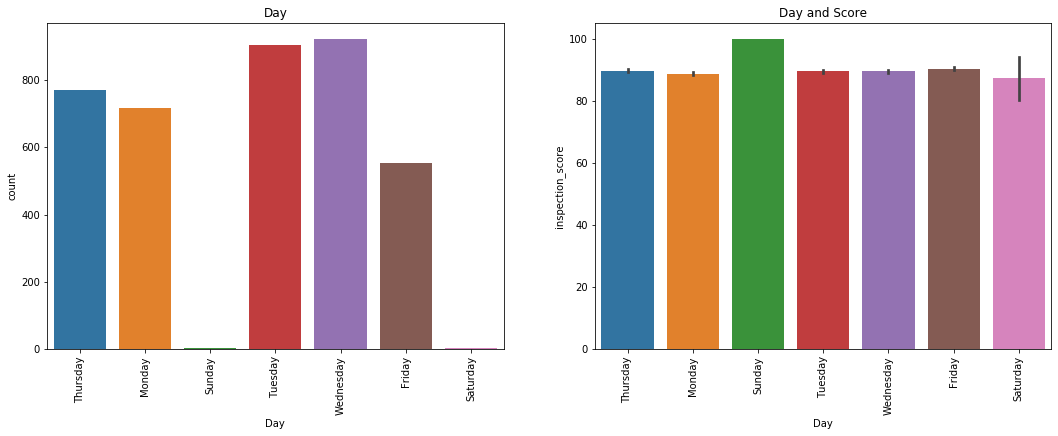

In [37]:
for column in cat_cols:
    plt.figure(figsize=(18, 6))
    
    plt.subplot(1, 2, 1)
    sns.countplot(df[column])
    plt.xticks(rotation='vertical')
    plt.title('{}'.format(column))
    
    plt.subplot(1, 2, 2)
    sns.barplot(x=column, y='inspection_score', data=df)
    plt.title('{} and Score'.format(column))
    plt.xticks(rotation='vertical')
    plt.show()

Ok, let's start getting our features and target ready for our models!

In [38]:
cat_features = ['num_violations', 'low_risk_count', 'medium_risk_count', 'high_risk_count', 'no_risk_count']

In [39]:
postal_code = pd.get_dummies(df['business_postal_code'], drop_first=True)
name = pd.get_dummies(df['business_name'], drop_first=True)
day = pd.get_dummies(df['Day'], drop_first=True)
year = pd.get_dummies(df['Year'], drop_first=True)
month = pd.get_dummies(df['Month'], drop_first=True)
date = pd.get_dummies(df['Date'], drop_first=True)

dummies_df = pd.concat([postal_code, name, day, year, month, date], axis=1)

In [40]:
X = pd.concat([numeric_columns, dummies_df], axis=1) 
X = X.drop(columns=['inspection_score'])
y = df['inspection_score']

### Random Forest Model

In [41]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [42]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=350, max_features='sqrt')
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=350,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [43]:
print('The r^2 of our test data is {}'.format(round(rfr.score(X_test, y_test), 4)))
print('The r^2 of our training data is {}'.format(round(rfr.score(X_train, y_train), 4)))

The r^2 of our test data is 0.4091
The r^2 of our training data is 0.9141


In [44]:
importance = rfr.feature_importances_
columns = X_train.columns

feature_df = pd.DataFrame()

feature_df['columns'] = columns
feature_df['importance'] = importance

feature_df.sort_values(by='importance', ascending=False).reset_index()[:10]

,index,columns,importance
0,8,review_sentiment,0.055597
1,5,yelp_rating,0.041237
2,7,review_rating,0.037366
3,0,Neighborhoods,0.029768
4,4,Analysis Neighborhoods,0.026705
5,3,Fire Prevention Districts,0.024844
6,934,starbucks,0.023897
7,2,Supervisor Districts,0.023118
8,1,Police Districts,0.020412
9,6,price,0.017913


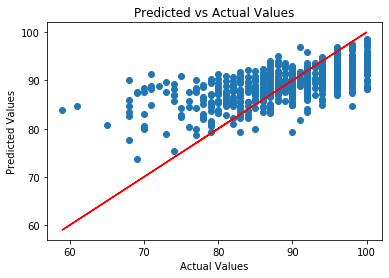

Root mean squared error of the prediction is: 5.503848265958506
Mean absolute percentage error of the prediction is: 4.754051049089454%


In [45]:
from statsmodels.tools.eval_measures import rmse

y_preds = rfr.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color='red')
plt.title('Predicted vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}%".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

Not too great and it seems to overfit significantly.

Let's attempt to add some unsupervised learning techniques and implement a supervised learning neural network.

We will say that either of these are better options if one of the two conditions below are met:

__1) Produces roughly the same R^2 value as our RFR, but reduces overfitting. This will be measured as the distance between the test and train sets.__

__2) Still overfits, but seems to increase the R^2 value of the test set by a significant margin.__

#1) Scale Features

#2) Cut down number of neurons

#3) Try different alphas

# Random Forest - w/RBM first

[HERE](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.BernoulliRBM.html#sklearn.neural_network.BernoulliRBM)

In [46]:
n_neurons = X.shape[1]

In [47]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import BernoulliRBM

rbm = BernoulliRBM(n_components=n_neurons)
X_N = rbm.fit_transform(X)

In [48]:
X_N.shape

(3876, 1194)

In [49]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_N, y, test_size=0.2)

In [50]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=350, max_features='sqrt')
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=350,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [51]:
print('The r^2 of our test data is {}'.format(round(rfr.score(X_test, y_test), 4)))
print('The r^2 of our training data is {}'.format(round(rfr.score(X_train, y_train), 4)))

The r^2 of our test data is -0.0
The r^2 of our training data is -0.0


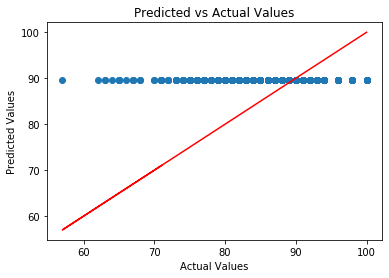

Root mean squared error of the prediction is: 7.690698497345392
Mean absolute percentage error of the prediction is: 7.052666228880687%


In [52]:
from statsmodels.tools.eval_measures import rmse

y_preds = rfr.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color='red')
plt.title('Predicted vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}%".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

# MLP only - tune with GridSearchCV

[HERE](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html)

In [53]:
n_neurons = int(round((X.shape[1] + 1) / 2, 0))

In [54]:
X.shape

(3876, 1194)

In [55]:
n_neurons

598

In [56]:
ranges = [0.0001, 0.001, 0.01, 0.1]

In [57]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

mlp = MLPRegressor(solver='lbfgs')

parameters = {'activation' : ('relu', 'logistic'), 'alpha' : ranges}

reg = GridSearchCV(mlp, parameters, cv=5)
reg.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=MLPRegressor(activation='relu', alpha=0.0001,
                                    batch_size='auto', beta_1=0.9, beta_2=0.999,
                                    early_stopping=False, epsilon=1e-08,
                                    hidden_layer_sizes=(100,),
                                    learning_rate='constant',
                                    learning_rate_init=0.001, max_iter=200,
                                    momentum=0.9, n_iter_no_change=10,
                                    nesterovs_momentum=True, power_t=0.5,
                                    random_state=None, shuffle=True,
                                    solver='lbfgs', tol=0.0001,
                                    validation_fraction=0.1, verbose=False,
                                    warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'activation': ('relu', 'logistic'),
                

In [58]:
print('The r^2 of our test data is {}'.format(round(reg.score(X_test, y_test), 4)))
print('The r^2 of our training data is {}'.format(round(reg.score(X_train, y_train), 4)))

The r^2 of our test data is -0.0
The r^2 of our training data is 0.0


In [59]:
reg.best_estimator_

MLPRegressor(activation='logistic', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.001, max_iter=200, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='lbfgs', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)

Well it appears our random forest greatly outperforms our feature extraction -> random forest and out multi-layer perceptron.

This isn't surprising given the small amount of records in this dataset.